In [219]:
%matplotlib inline

In [218]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import unicodedata
import re
import torch.optim as optim
import random
from tqdm import tqdm, tnrange, tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
SOS_TOKEN = 0
EOS_TOKEN = 1

In [59]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = dict()
        self.word2count = {}
        self.index2word = {0 : 'SOS', 1 : 'EOS'}
        self.n_words = 2
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addword(word)
    
    def addword(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [60]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [61]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [62]:
def readLangs(lang1, lang2, reverse=False):
    print('Read lines')
    
    lines = open('fra.txt', encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [63]:
MAX_LENGTH = 15

In [64]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [65]:
def filterpair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterpair(pair)]

In [66]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read lines
Read 169657 sentence pairs
Trimmed to 15588 sentence pairs
Counting words...
Counted words:
fra 5456
eng 3577
['elle est deux ans plus vieille que vous .', 'she is two years older than you .']


In [80]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_dim):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def inithidden(self):
        return torch.zeros(1, 1, self.hidden_dim, device=device)

In [81]:
class Decoder(nn.Module):
    
    def __init__(self, hidden_dim, output_size):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(output_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        embedded = self.embedding(x).view(1, 1, -1)
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def inithidden(self):
        return torch.zeros(1, 1, self.hidden_dim, device=device)

In [82]:
class AttentionDecoder(nn.Module):
    
    def __init__(self, hidden_dim, output_size, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.max_length = max_length
        
        self.embedding = nn.Embedding(output_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        self.attention = nn.Linear(hidden_dim*2, max_length)
        self.attention_combined = nn.Linear(hidden_dim*2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, encoder_output):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attention = F.softmax(self.attention(torch.cat([embedded[0], hidden[0]], dim=1)), dim=1)
        attention_applied = torch.bmm(attention.unsqueeze(0), encoder_output.unsqueeze(0))
        
        output = torch.cat((embedded[0], attention_applied[0]), 1)
        output = self.attention_combined(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attention
    
    def inithidden():
        return torch.zeros(1, 1, self.hidden_dim, device=device)

In [75]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [128]:
encoder = Encoder(input_lang.n_words, 256).to(device)
decoder = AttentionDecoder(256, output_lang.n_words).to(device)

In [129]:
encoder_optimizer = optim.Adam(params=encoder.parameters(), lr=1e-3)
decoder_optimizer = optim.Adam(params=decoder.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

In [138]:
random.shuffle(pairs)

In [146]:
def train():
    
    for epoch in tnrange(5, desc='epoch'):
        
        training_loss = 0.0
        for ii, pair in enumerate(tqdm_notebook(pairs, desc='step')):
            
            loss = 0.0
            input, target = tensorsFromPair(pair)
            input, target = input.to(device), target.to(device)
            input_length = input.shape[0]
            target_length = target.shape[0]
            
            encoder_hidden = encoder.inithidden().to(device)
            encoder_outputs = torch.zeros(MAX_LENGTH, 256).to(device)
            
            for i in range(input_length):
                encoder_output, encoder_hidden = encoder(input[i], encoder_hidden)
                encoder_outputs[i] = encoder_output[0,0]
            
            decoder_input = torch.tensor([SOS_TOKEN]).to(device).long()
            decoder_hidden = encoder_hidden
            
            use_teacher_forcing = True if random.random() < 0.5 else False
            
            for j in range(target_length):
                decoder_output, decoder_hidden, attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                if use_teacher_forcing:
                    decoder_input = target[j]
                else:
                    topv, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze().detach()
                
                loss += criterion(decoder_output, target[j])
                if decoder_input.item() == EOS_TOKEN:
                    break

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            training_loss += loss.item() / target_length
            
            if (ii+1) % 1000 == 0:
                print('Epoch %d | step %d | loss %0.4f' %(epoch+1, ii+1, training_loss / 1000))
                training_loss = 0.0

In [236]:
def evaluate(samples):
    
    eval_results = []
    attentions = []
    with torch.no_grad():
        for i, sample in enumerate(tqdm_notebook(samples)):
            input, target = tensorsFromPair(sample)
            input = input.to(device)
            input_length = input.shape[0]
            
            encoder_hidden = encoder.inithidden()
            encoder_outputs = torch.zeros(MAX_LENGTH, 256).to(device)
            
            for j in range(input_length):
                encoder_output, encoder_hidden = encoder(input[j], encoder_hidden)
                encoder_outputs[j] = encoder_output[0,0]
            
            decoder_hidden = encoder_hidden
            decoder_input = torch.tensor([SOS_TOKEN]).to(device).long()
            
            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)
            
            for k in range(MAX_LENGTH):
                decoder_output, decoder_hidden, attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[k] = attention.data
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
                if topi.item() == EOS_TOKEN:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.index2word[topi.item()])
                    
            eval_results.append([sample[0], decoded_words, sample[1]])
            attentions.append(decoder_attentions[:k+1])
    
    return eval_results, attentions

In [147]:
train()

Epoch 1 | step 1000 | loss 1.7017
Epoch 1 | step 2000 | loss 1.6528
Epoch 1 | step 3000 | loss 1.5856
Epoch 1 | step 4000 | loss 2.0681
Epoch 1 | step 5000 | loss 2.1012
Epoch 1 | step 6000 | loss 2.0896
Epoch 1 | step 7000 | loss 2.0207
Epoch 1 | step 8000 | loss 2.0080
Epoch 1 | step 9000 | loss 1.9692
Epoch 1 | step 10000 | loss 2.0038
Epoch 1 | step 11000 | loss 1.9672
Epoch 1 | step 12000 | loss 1.9565
Epoch 1 | step 13000 | loss 1.9233
Epoch 1 | step 14000 | loss 1.8973
Epoch 1 | step 15000 | loss 1.9754


Epoch 2 | step 1000 | loss 1.6521
Epoch 2 | step 2000 | loss 1.5799
Epoch 2 | step 3000 | loss 1.5120
Epoch 2 | step 4000 | loss 1.6059
Epoch 2 | step 5000 | loss 1.6916
Epoch 2 | step 6000 | loss 1.6553
Epoch 2 | step 7000 | loss 1.6243
Epoch 2 | step 8000 | loss 1.6126
Epoch 2 | step 9000 | loss 1.6042
Epoch 2 | step 10000 | loss 1.6242
Epoch 2 | step 11000 | loss 1.6231
Epoch 2 | step 12000 | loss 1.5667
Epoch 2 | step 13000 | loss 1.5670
Epoch 2 | step 14000 | loss 1.5596
Epoch 2 | step 15000 | loss 1.6507


Epoch 3 | step 1000 | loss 1.4960
Epoch 3 | step 2000 | loss 1.4430
Epoch 3 | step 3000 | loss 1.3679
Epoch 3 | step 4000 | loss 1.3831
Epoch 3 | step 5000 | loss 1.4671
Epoch 3 | step 6000 | loss 1.4319
Epoch 3 | step 7000 | loss 1.4684
Epoch 3 | step 8000 | loss 1.4512
Epoch 3 | step 9000 | loss 1.3982
Epoch 3 | step 10000 | loss 1.4437
Epoch 3 | step 11000 | loss 1.4270
Epoch 3 | step 12000 | loss 1.3770
Epoch 3 | step 13000 | loss 1.3767
Epoch 3 | step 14000 | loss 1.3556
Epoch 3 | step 15000 | loss 1.4542


Epoch 4 | step 1000 | loss 1.3580
Epoch 4 | step 2000 | loss 1.3161
Epoch 4 | step 3000 | loss 1.2670
Epoch 4 | step 4000 | loss 1.3028
Epoch 4 | step 5000 | loss 1.3454
Epoch 4 | step 6000 | loss 1.3457
Epoch 4 | step 7000 | loss 1.3308
Epoch 4 | step 8000 | loss 1.3374
Epoch 4 | step 9000 | loss 1.2998
Epoch 4 | step 10000 | loss 1.2863
Epoch 4 | step 11000 | loss 1.3398
Epoch 4 | step 12000 | loss 1.2730
Epoch 4 | step 13000 | loss 1.2464
Epoch 4 | step 14000 | loss 1.2258
Epoch 4 | step 15000 | loss 1.3461


Epoch 5 | step 1000 | loss 1.2629
Epoch 5 | step 2000 | loss 1.2458
Epoch 5 | step 3000 | loss 1.2178
Epoch 5 | step 4000 | loss 1.1594
Epoch 5 | step 5000 | loss 1.2425
Epoch 5 | step 6000 | loss 1.2732
Epoch 5 | step 7000 | loss 1.2968
Epoch 5 | step 8000 | loss 1.2838
Epoch 5 | step 9000 | loss 1.2607
Epoch 5 | step 10000 | loss 1.2767
Epoch 5 | step 11000 | loss 1.2363
Epoch 5 | step 12000 | loss 1.1904
Epoch 5 | step 13000 | loss 1.1944
Epoch 5 | step 14000 | loss 1.1778
Epoch 5 | step 15000 | loss 1.2742


In [239]:
def evalrandomly(pairs, num_samples):
    eval_samples = random.sample(pairs, num_samples)
    results, attention = evaluate(eval_samples)
    
    for input, pred, target in results:
        print('input :', input)
        print('Translated :', ' '.join(pred))
        print('target :', target)
        print('\n')
    
    return results, attention

In [220]:
import matplotlib.ticker as ticker

In [241]:
def showattention(sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticklabels([''] + sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
def evalandshow(pairs, num_samples):
    results, attention = evalrandomly(pairs, num_samples)
    for i in range(num_samples):
        showattention(results[i][0], results[i][1], attention[i])

input : je suis pret quand tu l es .
Translated : i m ready to you are . <EOS>
target : i m ready when you are .


input : je suis surpris que vous ignoriez cela .
Translated : i m surprised you didn that . <EOS>
target : i m surprised you didn t know that .


input : je ne suis pas si presse .
Translated : i am not in that much . <EOS>
target : i m not in that much of a hurry .




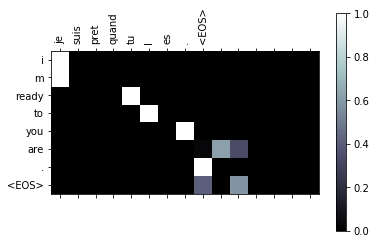

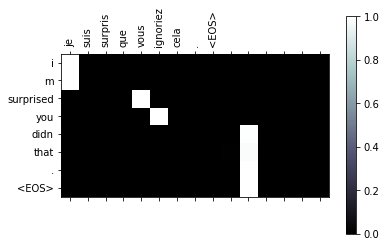

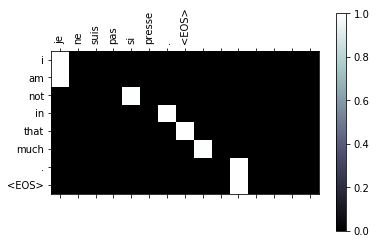

In [243]:
evalandshow(pairs, 3)